# I. **Import library**

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

In [38]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
# Declare parameters
batch_size = 64
epochs = 10
lr = 0.01

# **2. Load MNIST dataset**

In [40]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# MNIST dataset
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, transform=transform)

In [41]:
# Data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **3. Visualization**

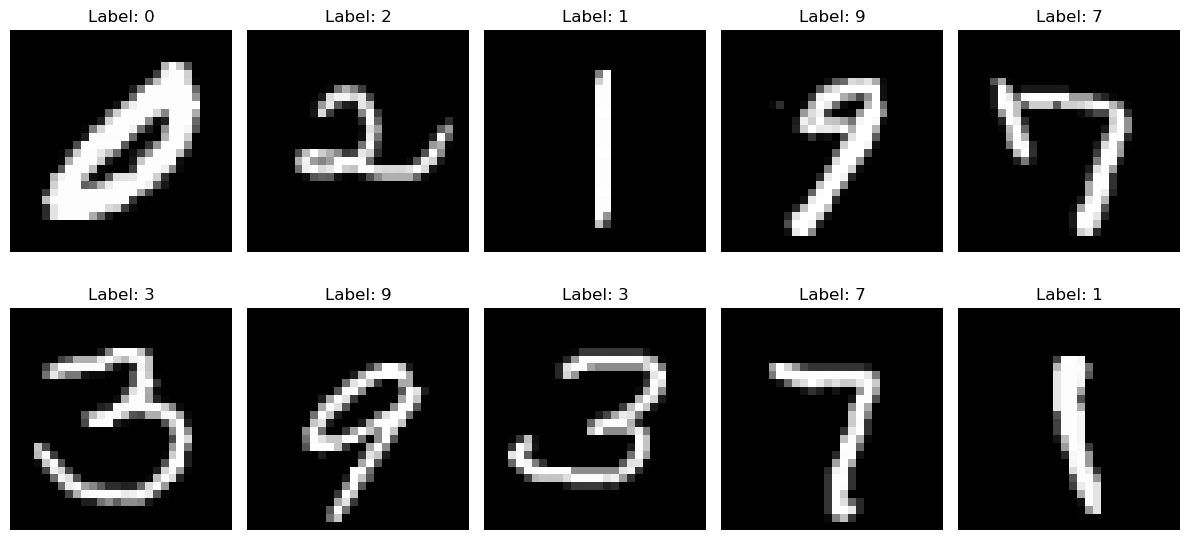

In [42]:
# Visualize some examples
def plot_samples(loader):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, (img, label) in enumerate(loader):
        if i >= 10:
            break
        ax = axes[i//5, i%5]
        ax.imshow(img[0].squeeze(), cmap='gray')
        ax.set_title(f'Label: {label[0].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_samples(train_loader)

# **4. Initialize Model**

In [43]:
# Define FNN model
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = FNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# **5. Prepare train and test functions**

In [44]:
# Train function
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    return sum(losses) / len(losses)

In [45]:
# Test function
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return test_loss, accuracy

# **7. Train model**

In [46]:
# Train model
num_epochs = 10
train_losses, test_losses, accuracies = [], [], []

for epoch in range(1, epochs + 1):
    train_loss = train(model, train_loader, optimizer, criterion, epoch)
    test_loss, accuracy = test(model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.336342
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.920237
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.159243
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.662839
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.666037
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.479078
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.522425
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.356075
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.217716
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.408603

Test set: Average loss: 0.0053, Accuracy: 9036/10000 (90.36%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.343701
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.288863
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.334061
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.341935
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.351544
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.227197
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.439489
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.347003
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.22255

# **8. Display loss and accuracy on train and test dataset**

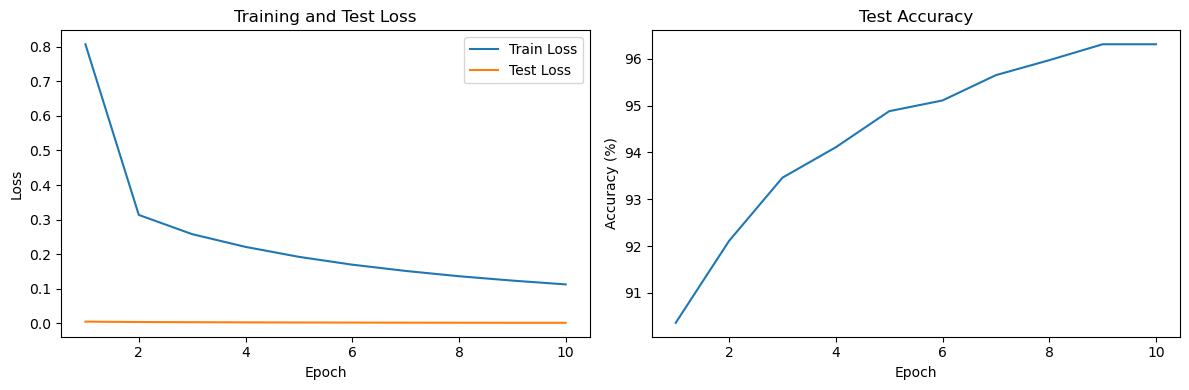

In [47]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')

plt.tight_layout()
plt.show()

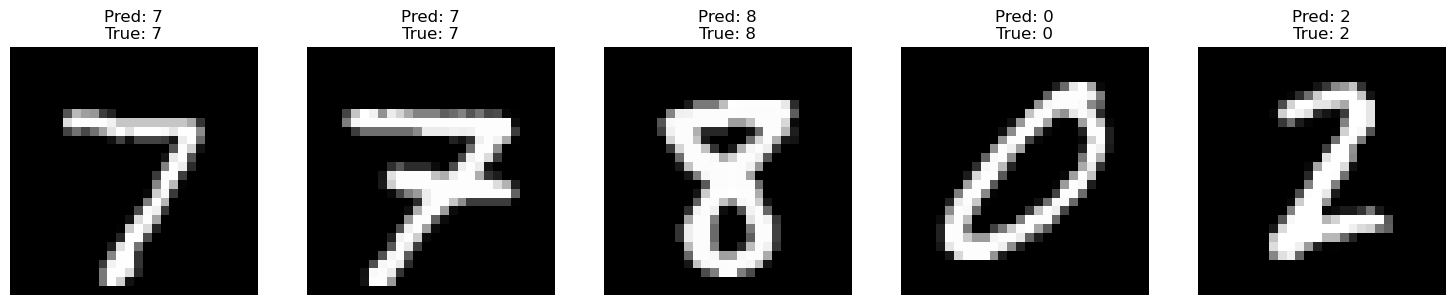

In [48]:
def visualize_predictions(model, test_loader, num_examples=5):
    model.eval()
    data_iter = iter(test_loader)
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    for i in range(num_examples):
        data, target = next(data_iter)
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        img = data[0].cpu().squeeze().numpy()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Pred: {pred[0].item()}\nTrue: {target[0].item()}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader)

# **9. Save model**

In [49]:
torch.save(model.state_dict(), './model_params/cnn.pt')

In [50]:
# How to load model parameters?
# state_dict = torch.load('./model_params/cnn.pt')
# new_model = FNN()
# new_model.load_state_dict(state_dict=state_dict)